# TP 4 – Volatilite stochastique (Heston) et calibration de modeles

Dans ce TP, nous allons:
- introduire le modele de volatilite stochastique de Heston;
- voir comment il est integre dans l'architecture Fourier de fypy;
- calibrer un modele Heston sur une surface synthetique de prix d'options a l'aide du module `fit` / `calibrate`.


In [26]:
# Imports pour le TP
import numpy as np
import matplotlib.pyplot as plt

from fypy.termstructures.DiscountCurve import DiscountCurve_ConstRate
from fypy.termstructures.EquityForward import EquityForward
from fypy.pricing.fourier.ProjEuropeanPricer import ProjEuropeanPricer
from fypy.model.sv.Heston import Heston
from fypy.market.MarketSurface import MarketSurface
from fypy.market.MarketSlice import MarketSlice
from fypy.fit.Targets import Targets
from fypy.fit.Calibrator import Calibrator, LeastSquares
from fypy.volatility.implied.ImpliedVolCalculator import ImpliedVolCalculator_Black76

%matplotlib inline

## 1. Modele de Heston : EDS et interpretation

Le modele de Heston decrit simultanement la dynamique du prix \( S_t \) et de la variance instantanee \( v_t \):
\[
\begin{aligned}
dS_t &= (r - q) S_t \, dt + \sqrt{v_t} \, S_t \, dW_t^S, \\
dv_t &= \kappa (\theta - v_t) \, dt + \sigma_v \sqrt{v_t} \, dW_t^v, \\
dW_t^S dW_t^v &= \rho \, dt.
\end{aligned}
\]

Les parametres ont l'interpretation suivante:
- \( v_0 \) : variance initiale;
- \( \theta \) : variance de long terme (niveau d'equilibre);
- \( \kappa \) : vitesse de retour a la moyenne;
- \( \sigma_v \) : volatilite de la variance (vol-of-vol);
- \( \rho \) : correlation entre les chocs de prix et de variance.

Sous la mesure risque neutre, le drift du prix est \( r - q \) comme dans Black Scholes, mais la volatilite devient
un processus stochastique. Ce type de modele permet de generer naturellement des smiles et skews de volatilite
implicite (asymetrie, convexite), mieux adaptes aux donnees de marche.

## 2. Exemple de smile Heston a partir de PROJ

Nous allons:
- fixer des parametres Heston raisonnables;
- calculer les prix d'options europeennes via `ProjEuropeanPricer`;
- en deduire les volatilites implicites Black-76 et tracer le smile.

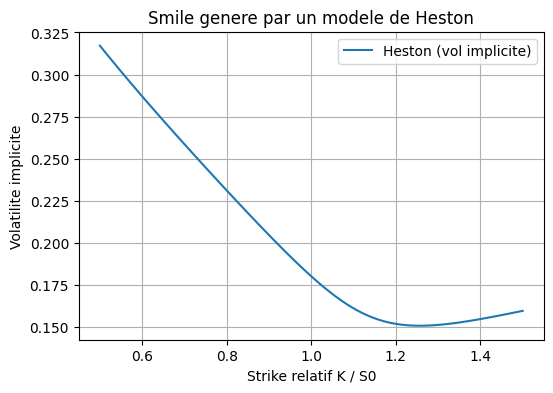

In [27]:
# Parametres de marche
S0 = 100.0
r = 0.01
q = 0.0
T = 1.0

disc_curve = DiscountCurve_ConstRate(rate=r)
div_disc = DiscountCurve_ConstRate(rate=q)
fwd_curve = EquityForward(S0=S0, discount=disc_curve, divDiscount=div_disc)

# Parametres Heston "vrais" (utilises pour generer des prix)
v0_true = 0.04
theta_true = 0.04
kappa_true = 1.5
sigma_v_true = 0.5
rho_true = -0.6

modele_heston_true = Heston(forwardCurve=fwd_curve,
                            discountCurve=disc_curve,
                            v_0=v0_true,
                            theta=theta_true,
                            kappa=kappa_true,
                            sigma_v=sigma_v_true,
                            rho=rho_true)

pricer_heston = ProjEuropeanPricer(model=modele_heston_true, N=2 ** 12, L=17.0)

strikes = np.linspace(50.0, 150.0, 80)
is_calls = np.zeros(len(strikes), dtype=bool)  # puts pour visualiser le skew

prix_heston = pricer_heston.price_strikes(T=T, K=strikes, is_calls=is_calls)

ivc = ImpliedVolCalculator_Black76(disc_curve=disc_curve, fwd_curve=fwd_curve)
vols_heston = ivc.imply_vols(strikes=strikes, prices=prix_heston, is_calls=is_calls, ttm=T)
rel_strikes = strikes / S0

plt.figure(figsize=(6, 4))
plt.plot(rel_strikes, vols_heston, label='Heston (vol implicite)')
plt.xlabel('Strike relatif K / S0')
plt.ylabel('Volatilite implicite')
plt.title('Smile genere par un modele de Heston')
plt.grid(True)
plt.legend()
plt.show()

On observe un smile typiquement **asymetrique** (skew) lorsque \( \rho < 0 \): les puts OTM sont plus chers que
dans un monde gaussien, ce qui se traduit par des volatilites implicites plus elevees pour les strikes faibles.

## 3. Calibration : principe general

On suppose maintenant que l'on observe un certain nombre de prix d'options \( P_i^{\text{mkt}} \) (ou vols implicites)
pour differents strikes et maturites. L'objectif de la **calibration** est de trouver un vecteur de parametres
\( \theta = (v_0, \theta, \kappa, \sigma_v, \rho) \) tel que les prix du modele \( P_i^{\text{mod}}(\theta) \)
reproduisent au mieux les prix observes.

Une approche classique est le **moindre carres**:
\[
\min_{\theta} \sum_i w_i \big( P_i^{\text{mod}}(\theta) - P_i^{\text{mkt}} \big)^2.
\]

Dans fypy:
- un modele comme `Heston` implemente l'interface `Calibratable` (avec `get_params`, `set_params`, `num_params`, etc.);
- la classe `Targets` represente un ensemble de cibles (prix marche) et la fonction qui calcule les prix modele;
- la classe `Calibrator` orchestre l'appel a un minimiseur (ici `LeastSquares`) et met a jour les parametres du modele.

## 4. Construction d'une surface synthetique et calibration

Pour illustrer la procedure, nous allons:
1. generer une *surface synthetique* de prix d'options a partir d'un modele Heston "vrai" (parametres connus);
2. construire un objet `MarketSurface` a partir de ces prix;
3. definer une fonction `targets_pricer` qui, pour un vecteur de parametres donne, recalcule tous les prix modele;
4. utiliser `Calibrator` pour retrouver les parametres a partir des prix synthetiques.


In [28]:
# 4.1. Generation d'une surface synthetique de prix Heston
surface = MarketSurface(forward_curve=fwd_curve, discount_curve=disc_curve)

ttms = [0.25, 0.5, 1.0, 2.0]  # maturites
strikes = np.arange(60.0, 140.0, 10.0)
is_calls = np.ones(len(strikes), dtype=bool)

prix_cibles = []

for ttm in ttms:
    prix_slice = pricer_heston.price_strikes(T=ttm, K=strikes, is_calls=is_calls)
    mkt_slice = MarketSlice(T=ttm,
                            F=fwd_curve(ttm),
                            disc=disc_curve(ttm),
                            strikes=strikes,
                            is_calls=is_calls,
                            mid_prices=prix_slice)
    surface.add_slice(ttm, mkt_slice)
    prix_cibles.append(prix_slice)

prix_cibles = np.concatenate(prix_cibles)
print('Nombre total de points de marche dans la surface synthetique :', len(prix_cibles))

Nombre total de points de marche dans la surface synthetique : 32


In [29]:
# 4.2. Fonction qui recalcule tous les prix modele (pour un jeu de parametres donne)
def targets_pricer() -> np.ndarray:
    toutes_les_prix = []
    for ttm, mkt_slice in surface.slices.items():
        prix = pricer_heston.price_strikes(T=ttm, K=mkt_slice.strikes, is_calls=mkt_slice.is_calls)
        toutes_les_prix.append(prix)
    return np.concatenate(toutes_les_prix)

# Remarque : la fonction ci-dessus utilise l'objet `pricer_heston`,
# qui lui-meme utilise les parametres courants du modele Heston associe.

In [30]:
# 4.3. Mise en place du calibrateur
# On cree un nouveau modele Heston a calibrer, avec une valeur initiale approximative
modele_heston_calib = Heston(forwardCurve=fwd_curve,
                             discountCurve=disc_curve,
                             v_0=0.02,
                             theta=0.05,
                             kappa=1.0,
                             sigma_v=0.3,
                             rho=-0.3)

# On reutilise le meme pricer PROJ, mais connecte au modele a calibrer
pricer_heston_calib = ProjEuropeanPricer(model=modele_heston_calib, N=2 ** 12, L=17.0)

def targets_pricer_calib() -> np.ndarray:
    toutes_les_prix = []
    for ttm, mkt_slice in surface.slices.items():
        prix = pricer_heston_calib.price_strikes(T=ttm, K=mkt_slice.strikes, is_calls=mkt_slice.is_calls)
        toutes_les_prix.append(prix)
    return np.concatenate(toutes_les_prix)

# Creation de l'objet Targets (prix de marche vs prix modele)
targets = Targets(targets=prix_cibles, function=targets_pricer_calib)

# Creation du calibrateur
calibrator = Calibrator(model=modele_heston_calib, minimizer=LeastSquares())
# IMPORTANT : on force la condition initiale du solveur a partir des parametres courants du modele,
# plutot que d'utiliser model.default_params() qui peut varier selon l'implementation.
calibrator.set_initial_guess(modele_heston_calib.get_params())
calibrator.add_objective('Targets', targets)

print('Parametres initiaux (devines) :', modele_heston_calib.get_params())

Parametres initiaux (devines) : [ 0.02  0.05  1.    0.3  -0.3 ]


In [31]:
# 4.4. Lancement de la calibration
# Attention : cette etape peut etre relativement couteuse selon le nombre de points
result = calibrator.calibrate()

params_calib = modele_heston_calib.get_params()
params_true = modele_heston_true.get_params()

print('Parametres vrais     :', params_true)
print('Parametres calibres :', params_calib)
print('\nResume de l\'optimisation :')
print('Nombre d\'iterations :', result.n_iter)
print('Valeur finale de la fonction objectif :', result.loss)

Parametres vrais     : [ 0.04  0.04  1.5   0.5  -0.6 ]
Parametres calibres : [ 0.04  0.04  1.5   0.5  -0.6 ]

Resume de l'optimisation :


AttributeError: 'OptResult' object has no attribute 'n_iter'

Si tout se passe bien, les parametres calibres sont proches des parametres vrais utilises pour generer la surface.
Les ecarts residuels proviennent de la discretisation numerique (PROJ) et du fait que l'on ajuste un nombre fini
de points.

## 5. Pour aller plus loin

Quelques pistes de travaux complementaires:
- Ajouter du bruit a la surface synthetique pour imiter des erreurs de cotation, puis recalibrer;
- Explorer l'impact du choix des poids \( w_i \) (par exemple ponderation par l'inverse du bid-ask);
- Changer la parametrisation (par exemple calibrer sur les vols implicites plutot que sur les prix);
- Combiner plusieurs objectifs dans `Calibrator` (targets sur prix, penalites sur la regularite de la surface, etc.).

Avec ce TP, vous avez vu comment:
- utiliser un modele de volatilite stochastique (Heston) dans fypy;
- generer une surface de prix via PROJ;
- calibrer un modele sur ces donnees a l'aide du module `fit` / `calibrate`.
